# CSCA-5642, Histopathologic Cancer Detection

# Brief description of the problem and data


In this notebook I'm training different CNNs to find the best model for detecting metastatic cancer in small image patches provided by PatchCamelyon (PCam) and preprocessed by Kaggle.

## Dataset
The dataset consists of two parts: the labeled one used for model training and validation, and the unlabeled for prediction, for participating in the competition. All the files in both parts are 96x96 RGB tiff images

* train: 220025 files, 5.72 GB
* test: 57458 files, 1.49 GB

Labels are given as a `train_labels.csv` file with two columns: `id` (file name without extension) and `label` - binary, 0 or 1. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.


At Kaggle the dataset and working directory are mounted to this paths:

In [1]:
DATASET_DIR = '/kaggle/input/histopathologic-cancer-detection/'
WORKING_DIR = '/kaggle/working/'

# Exploratory Data Analysis (EDA)

To get a brief overview let's take a look at the csv files, and a few images.

In [2]:
from os import path
import pandas as pd

df = pd.read_csv(path.join(DATASET_DIR, 'train_labels.csv'))
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


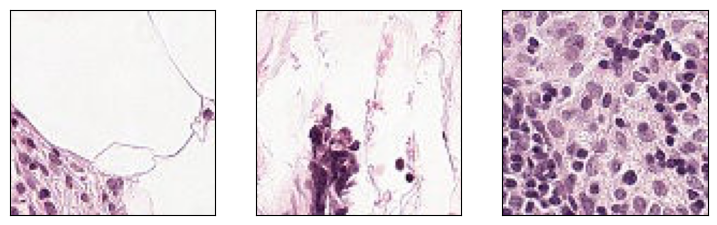

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(9,3))
for i in range(3):
    filename = f'{df.iloc[i]["id"]}.tif'
    filepath = path.join(DATASET_DIR, 'train', filename)
    img = plt.imread(filepath)
    ax[i].imshow(img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

## Label distribution
The labels are not evenly distributed, there are more negative than positive samples. The ratio is approximately 60/40:

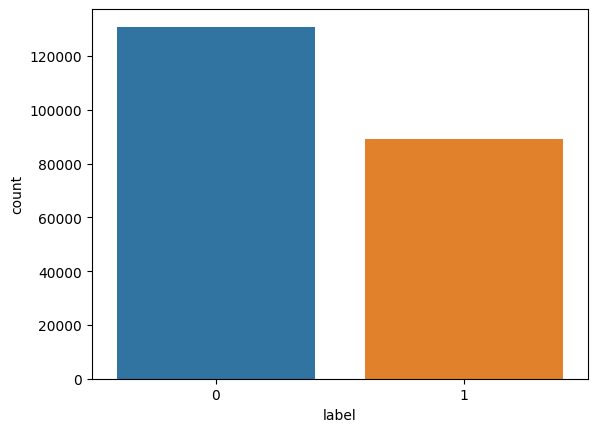

label==0: 130908
label==1: 89117


In [4]:
import seaborn as sns
sns.countplot(x='label', data=df)
plt.show()

print('label==0:', df[df['label']==0].shape[0])
print('label==1:', df[df['label']==1].shape[0])

## Low contrast images

Although most of the images are good and sharp, there are multiple not very good, very low contrast. From a human standpoint they don't bring much value and must be considered "corrupted", but they can still be used for training just because the robust model should perform OK on the corrupted images too. Here are some from the "training" subset, there are many like these in the "tests" subset too. I considered retaining them since there is no easy formula to identify *outlierness*.

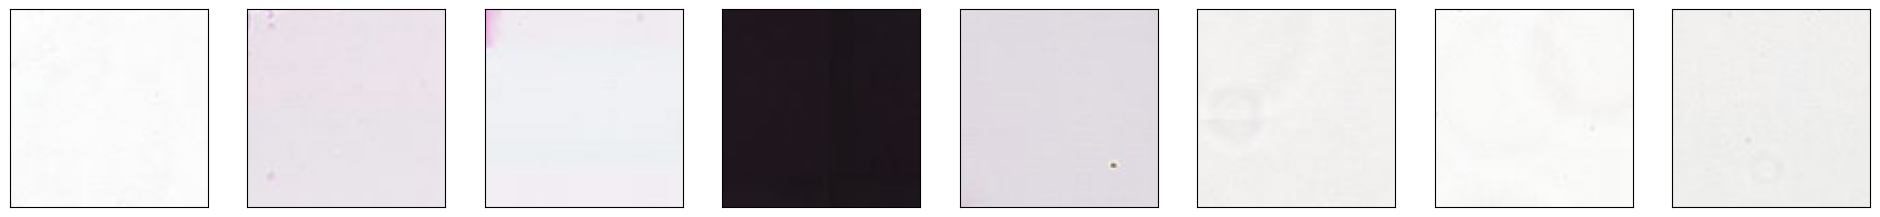

In [5]:
bad = [
    '0b2f343898d4024405b49ba444557805347c847a',
    'c3b79e987d08f06dd0d50aa18795dc8e37b755d8',
    'd321cbdeed2fcaa4adb3a2eeda922f09b6e62e0d',
    '38d5d6c3ff5cb0d04fc1db4cb23fd16f741fc2e7',
    '8238f435dbc15f5ee93aa4c4645d0e609d8c8a7f',
    '7f88140c49153bc3a7fb9329c64e1b50831c1e73',
    'a3a379c46de812f44a7e70c5018e924371f7c4f6',
    'e6e2c102bc7a78ecb7630d7281a0e169bd581572',
]

fig, ax = plt.subplots(1,len(bad),figsize=(3*len(bad),3))
for i in range(len(bad)):
    filename = f'{bad[i]}.tif'
    filepath = path.join(DATASET_DIR, 'train', filename)
    img = plt.imread(filepath)
    ax[i].imshow(img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()


## Data preprocessing

Keras TensorFlow has a few ways to feed images into the model being trained or evaluated. The most convenient of them looks to be `tf.keras.preprocessing.image_dataset_from_directory`, but unfortunately for some reason it doesn't support tiff images. An alternative approach would be `tf.data.Dataset.from_tensor_slices` and following the way: Dataset.map -> tf.numpy_function -> PIL.Image.open and load tiff images on the fly, but I found it extremely slow. I eventually leaned towards converting the dataset into one of the supported image formats and utilizing the fast `image_dataset_from_directory` approach, but there was a caveat: which format image to choose? Tiff wouldn't work:
~~~
ValueError: No images found in directory /kaggle/input/histopathologic-cancer-detection-working/test. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')
~~~

## Why not jpeg

After training a simple model with `from_tensor_slices` I migrated to `image_dataset_from_directory` to evolve the rest from there. I converted the test dataset to jpegs, re-ran the test, re-uploaded the submission to Kaggle and observed a noticeable drop in numbers. After manually expecting the samples I found this problem, let me plot it:

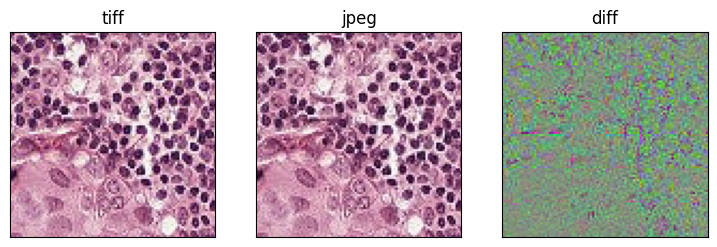

In [6]:
import io
from PIL import Image
import numpy as np

buf = io.BytesIO()
tif = Image.open(path.join(DATASET_DIR, 'test', '725dabe6ecccc68b958a2c7dd75bcbf362c7cb03.tif'))
tif.save(buf, format='JPEG', quality=95)
buf.seek(0)

jpg = Image.open(buf)

fig, axes = plt.subplots(1,3,figsize=(9,3))

axes[0].imshow(tif)
axes[1].imshow(jpg)

diff = np.array(jpg, dtype=np.float32) - np.array(tif, dtype=np.float32)
diff = (diff - diff.min(axis=(0,1))) / (diff.max(axis=(0,1)) - diff.min(axis=(0,1)))
axes[2].imshow(diff)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])


axes[0].set_title('tiff')
axes[1].set_title('jpeg')
axes[2].set_title('diff')

plt.show()

Jpeg format introduces quite a bit of hidden regularities, they seem to affect the prediction quality, eventually I decided to just convert everything to bmp.

## Center 32x32 patch


The dataset description says: *A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.*. This looked promising to carve the 32x32 out of the test images and only focus on this small patch, but compared to the original 96x96 the quality didn't improve. I tried multiple approaches:

1. Crop the 32x32 center, drop the rest
2. Pad everything around the patch with the mean color
3. Tile 96x96 with 32x32 patches.

In [7]:
IMG_SIZE = 96
TILE_SIZE = 32

def zoom_cetner_pacth(img):    
    result = img.crop((TILE_SIZE, TILE_SIZE, 2*TILE_SIZE, 2*TILE_SIZE))
    result = result.resize((IMG_SIZE, IMG_SIZE))
    return result

def keep_center_patch_pad_rest(img):
    arr = np.array(img)
    center_patch = arr[TILE_SIZE:2*TILE_SIZE, TILE_SIZE:2*TILE_SIZE, :]
    mean_color = center_patch.mean(axis=(0,1)).astype(np.uint8)
    result = np.ones_like(arr, dtype=np.uint8) * mean_color
    result[TILE_SIZE:2*TILE_SIZE, TILE_SIZE:2*TILE_SIZE, :] = center_patch
    return Image.fromarray(result)

def tile_with_cetner_patch(img):
    arr = np.array(img)
    center_patch = arr[TILE_SIZE:2*TILE_SIZE, TILE_SIZE:2*TILE_SIZE, :]
    result = np.tile(center_patch, (3, 3, 1))
    return Image.fromarray(result)

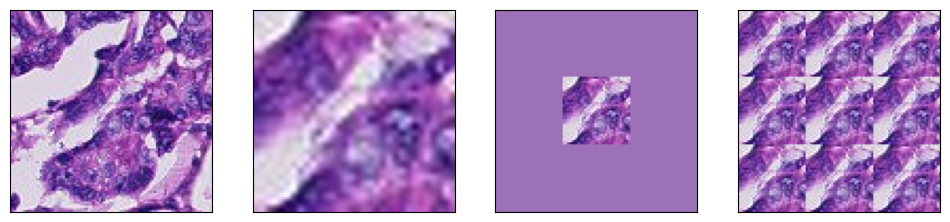

In [8]:
tif = Image.open(path.join(DATASET_DIR, 'test', '0000ec92553fda4ce39889f9226ace43cae3364e.tif'))

fig, axes = plt.subplots(1,4,figsize=(12,3))

axes[0].imshow(tif)
axes[1].imshow(zoom_cetner_pacth(tif))
axes[2].imshow(keep_center_patch_pad_rest(tif))
axes[3].imshow(tile_with_cetner_patch(tif))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

But nothing actually worked. I uploaded all the results to the competition and all the alternative approaches gave worse scores. So I decided to stay with 96x96 with no other preprocessing than just converting to BMP. It probably means that not only the path itself, but also the surrounding context is important in this classification task.

In [9]:
from concurrent.futures import ThreadPoolExecutor

MAX_WORKERS = 16

def copy_chunk_tiff_jpeg(file_ids, dir_from, dir_to, transform):
    for id in file_ids:
        path_from = path.join(dir_from, f'{id}.tif')
        path_to = path.join(dir_to, f'{id}.bmp')
        img = Image.open(path_from)
        img = img.convert('RGB')

        if transform:
            img = transform(img)

        img.save(path_to, format='BMP')

def copy_tiff_jpeg(file_ids, dir_from, dir_to, transform=None):
    chunks = [file_ids.iloc[i::MAX_WORKERS] for i in range(MAX_WORKERS)]
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        executor.map(lambda chunk: copy_chunk_tiff_jpeg(chunk, dir_from, dir_to, transform), chunks)

In [10]:
dataset_train = path.join(DATASET_DIR, 'train')
dataset_test = path.join(DATASET_DIR, 'test')

working_train = path.join(WORKING_DIR, 'train')
working_test = path.join(WORKING_DIR, 'test')

In [11]:
from os import makedirs

# Convert the training samples to jpegs
if not path.exists(working_train):
    working_train_0 = path.join(working_train, '0')
    working_train_1 = path.join(working_train, '1')
    
    makedirs(working_train_0, exist_ok=True)
    makedirs(working_train_1, exist_ok=True)
    
    df = pd.read_csv(path.join(DATASET_DIR, 'train_labels.csv'))
    train_ids0 = df[df['label'] == 0]['id']
    train_ids1 = df[df['label'] == 1]['id']
    
    copy_tiff_jpeg(train_ids0, dataset_train, working_train_0)
    copy_tiff_jpeg(train_ids1, dataset_train, working_train_1)


# And the test samples as well
if not path.exists(working_test):
    makedirs(working_test, exist_ok=True)
    df = pd.read_csv(path.join(DATASET_DIR, 'sample_submission.csv'))
    test_ids = df['id']
    
    copy_tiff_jpeg(test_ids, dataset_test, working_test)

# Model Architecture


Since it's an image classification, image structure recognition task, it's reasonable to try CNN. But the actual CNN details are not obvious to guess with a quick glance. I just trained a few models with different characteristics and ran the training algorithms to compare the metrics. There was no particular logic to follow, I only wanted the models to be small enough and fast to train. I also wanted the majority of training parameters to be concentrated at convolutional layers, not at the dense layer. So there are the models I tried:

1. Some baseline model
2. Almost the same, but strides=2 instead of max-pooling
3. While experimenting I discovered that the previous model overfits fast. here I just added some disturbance: RandomFlip, RandomRotation
4. Generalizing with BatchNormalization, small dense layer
5. The same as above, but ReLU activation *after* normalization, so it first shifts to mean values before trimming the negative range. Also a little bigger dense layer




In [13]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input

def make_baseline_model():
    return Sequential(name='baseline', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_strided_model():
    return Sequential(name='strided', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), strides=2, activation='relu'),
        Conv2D(64, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_disturbed_model():
    return Sequential(name='disturbed', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        RandomFlip(),
        RandomRotation(factor=(-0.1, 0.1)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), strides=2, activation='relu'),
        Conv2D(64, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_normalized_model():
    return Sequential(name='normalized', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def make_tweaked_model():
    return Sequential(name='tweaked', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(64, (3, 3)),
        MaxPooling2D((2, 2)),        
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (3, 3)),
        Activation('relu'),
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


The batch size itself could be considered a hyperparameter. Smaller the batch size - the more agile the gradient descent is. I tried multiple values for it and stopped at `BATCH_SIZE=512` - first of all it "stabilizes" the models, second - it optimally utilizes resources, so the learning is eventually faster

In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 512
SEED = 5642

train_ds, val_ds = image_dataset_from_directory(
    working_train,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    validation_split=0.1,
    shuffle=True,
    subset='both',
    seed=SEED)

Found 220025 files belonging to 2 classes.
Using 198023 files for training.
Using 22002 files for validation.


There is no clear criterion which metric to monitor. The labels are a little imbalanced, so "f1_score" would theoretically work better than "accuracy", but I noticed that this metric is very unstable - it can soar on one iteration, and dip in another. High values of validation f1_score don't necessarily correspond to high scores in test datasets. Since in this competition we are evaluated by "auc", I'll be using "val_auc" as the *deciding* metric to update the best model or not. All the other metrics are supplementary to visually control the convergence

In [16]:
import json
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

def run_training(model, results_dir, epochs=40, save_best_only=True):
    model_file_path = path.join(results_dir, model.name + '_epoch_{epoch:02d}_val_loss_{val_loss:.3f}.keras')
    history_file_path = path.join(results_dir, model.name + '_history.json')

    if path.exists(history_file_path):
        print(f'Training of the {model.name} model has already completed.')
        print(f'If want to retrain with different settings, please manually delete the artifact: {history_file_path}')
        return
        
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['binary_accuracy', 'auc', 'f1_score'])

    checkpoint_cb = ModelCheckpoint(
        monitor='val_auc',
        mode='max',
        filepath=model_file_path,
        save_best_only=save_best_only,
        save_freq='epoch'
    )

    print(f'About to start training the model {model.name}')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[checkpoint_cb]
    )
    
    with open(history_file_path, 'w') as f:
        json.dump(history.history, f, indent=4)


def run_training_all(models, results_dir):
    makedirs(results_dir, exist_ok=True)
    for model in models:
        tf.keras.backend.clear_session()
        run_training(model, results_dir)

The training is unfortunately not very fast, and time to time sessions unexpectedly terminate. I'm retaining the results where possible, so in the output of the following snippet you will see the "already completed" messages rather than the progress.


In [17]:
models = [
    make_baseline_model(),
    make_strided_model(),
    make_disturbed_model(),
    make_normalized_model(),
    make_tweaked_model()
]

results_dir = path.join(WORKING_DIR, f'BATCH{BATCH_SIZE:03}_SEED{SEED:04}')
run_training_all(models, results_dir)

Training of the baseline model has already completed.
If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED5642/baseline_history.json
Training of the strided model has already completed.
If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED5642/strided_history.json
Training of the disturbed model has already completed.
If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED5642/disturbed_history.json
Training of the normalized model has already completed.
If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED5642/normalized_history.json
Training of the tweaked model has already completed.
If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED5642/tweaked_history.json


# Results and Analysis


First of all, let's plot all the metrics we have

In [18]:
stats = dict()
model_names = [model.name for model in models]
for model_name in model_names:
    history_path = path.join(results_dir, f'{model_name}_history.json')
    with open(history_path, 'r') as f:
        stats[model_name] = json.load(f)

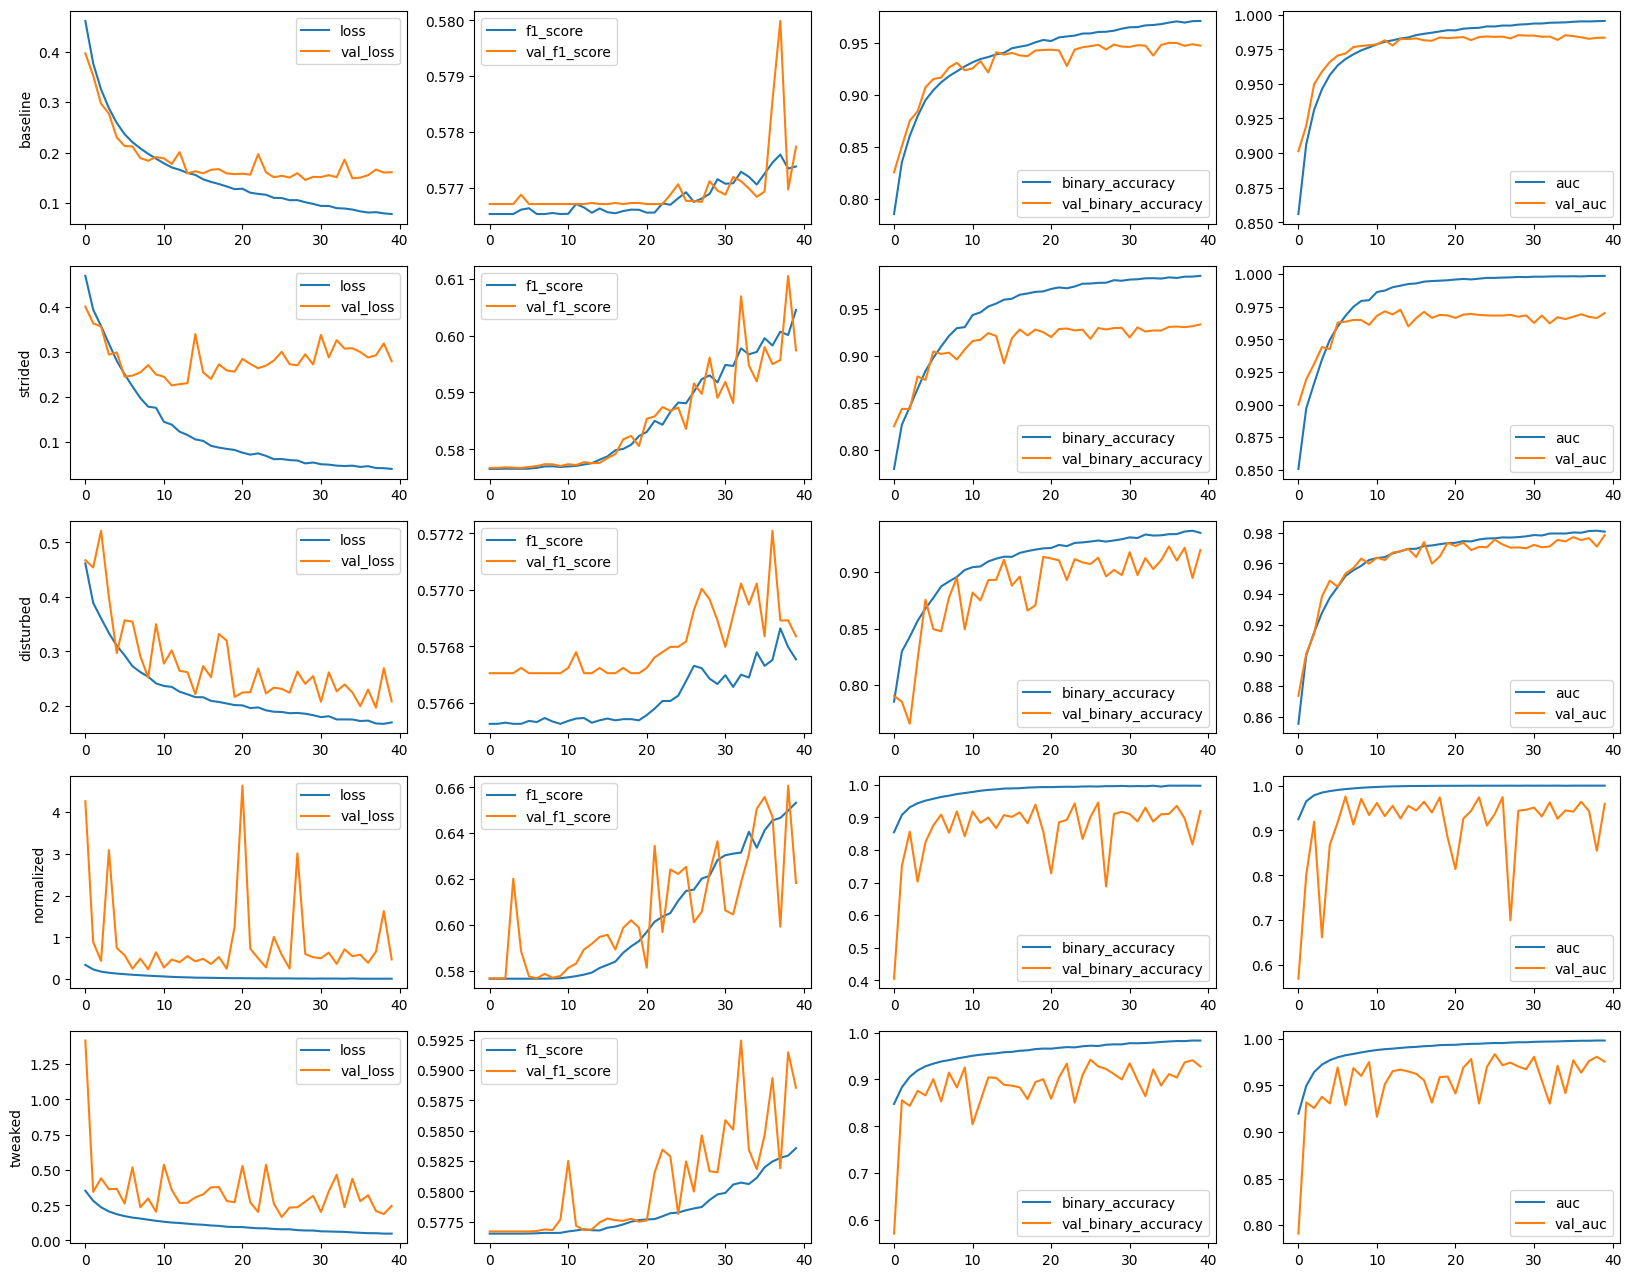

In [19]:
metrics = ['loss','f1_score','binary_accuracy','auc']

n = len(model_names)
m = len(metrics)

fig, axes = plt.subplots(n,m,figsize=(n*4,m*4))

for i,model_name in enumerate(model_names):
    for j,metric in enumerate(metrics):
        axes[i][0].set_ylabel(model_name)
        axes[i][j].plot(stats[model_name][metric], label=metric)
        axes[i][j].plot(stats[model_name]['val_'+metric], label='val_'+metric)
        axes[i][j].legend()
        

plt.show()

Now separately "val_auc" of all the models

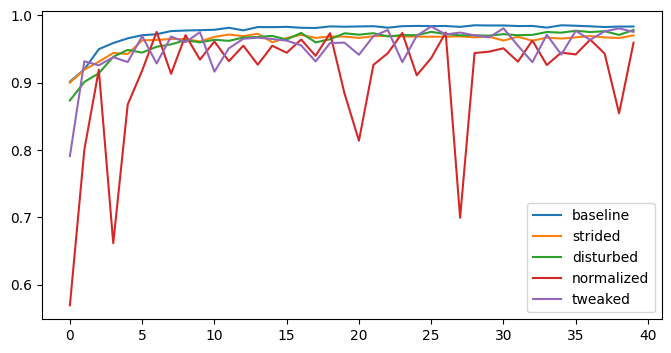

In [20]:
fig, axes = plt.subplots(1,1,figsize=(8,4))

for model_name in model_names:
    plt.plot(stats[model_name]['val_auc'], label=model_name)
    plt.legend()

plt.show()

I see that the models with `BatchNormalization` are very unstable. I wish I knew how to tackle them properly

## Submission


This is how I'm creating the submission files to upload to the competition

In [21]:
test_ds = image_dataset_from_directory(
    working_test,
    labels=None,
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=False)

test_ids = [p[-44:-4] for p in test_ds.file_paths]
df = pd.DataFrame({'id': test_ids})

Found 57458 files.


In [23]:
from os import listdir

all_files_sorted = sorted(listdir(results_dir))

for model_name in model_names:
    best_model_file = [f for f in all_files_sorted if f.startswith(model_name) and f.endswith('.keras')][-1]
    best_model_path = path.join(results_dir, best_model_file)
    model = tf.keras.models.load_model(best_model_path)

    df['label'] = model.predict(test_ds)

    best_model_file_no_ext, _ = path.splitext(best_model_file)
    submission_file_path = path.join(results_dir, f'{best_model_file_no_ext}.csv')
    df.to_csv(submission_file_path, index=False)

    print('Saved results to: ', submission_file_path)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
Saved results to:  /kaggle/working/BATCH512_SEED5642/baseline_epoch_29_val_loss_0.146.csv
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
Saved results to:  /kaggle/working/BATCH512_SEED5642/strided_epoch_14_val_loss_0.231.csv
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Saved results to:  /kaggle/working/BATCH512_SEED5642/disturbed_epoch_40_val_loss_0.208.csv
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
Saved results to:  /kaggle/working/BATCH512_SEED5642/normalized_epoch_07_val_loss_0.251.csv
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
Saved results to:  /kaggle/working/BATCH512_SEED5642/tweaked_epoch_26_val_loss_0.166.csv


In [24]:
df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,9.999673e-01
1,0000ec92553fda4ce39889f9226ace43cae3364e,7.040427e-01
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,9.912919e-01
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,5.069069e-08
4,000270442cc15af719583a8172c87cd2bd9c7746,1.895057e-03


## ROC curve

To plot a ROC curve we need both "true" and "predicted" labels. Since I defined test and validation datasets generators with `shuffle=True` param, they won't generate two identical sequences, can't be used here. Instead let me define a new deterministic generator so we can put *true* and *prediced* side by side.

In [25]:
full_ds = image_dataset_from_directory(
    working_train,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=False)

y_true = np.concatenate([y for x, y in full_ds], axis=0)

Found 220025 files belonging to 2 classes.


430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step


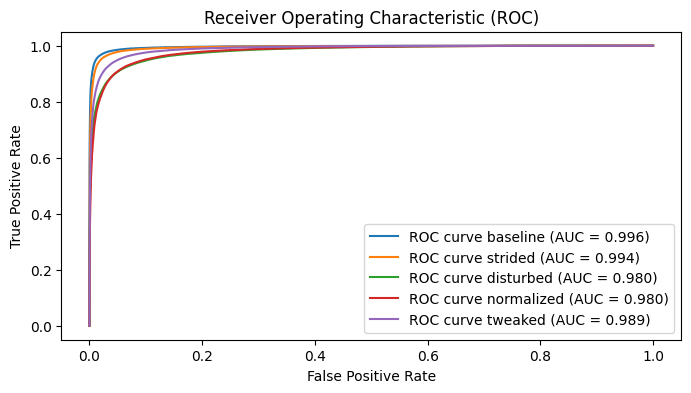

In [26]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,4))

for model_name in model_names:
    best_model_file = [f for f in all_files_sorted if f.startswith(model_name) and f.endswith('.keras')][-1]
    best_model_path = path.join(results_dir, best_model_file)
    model = tf.keras.models.load_model(best_model_path)
    y_pred = model.predict(full_ds)

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"ROC curve {model_name} (AUC = {roc_auc:.3f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


## Results


Here are the private and public scores evaluated by Kaggle:


| Model      | Epochs | Private   | Public    |
|------------|--------|-----------|-----------|
| Baseline   |   29   |  0.8873   |  0.9361   |
| Strided    |   14   |  0.8830   |  0.9015   |
| Disturbed  |   40   |  0.8520   |  0.9263   |
| Normalized |    7   |  0.8897   |  0.9349   |
| Tweaked    |   26   |  0.8497   |  0.9334   |


# Conclusion


If I participated in a real competition I would end somewhere at the end of the first thousand. Not very impressive, but I'm admitting that the modeling and training was rather try-and-observe rather than consciously engineering. If I had more time to dedicate to this competition I would try:


1. Longer training, 40 epochs wasn't enough for some of the models to converge. 
2. Tweaking level by level. I wish I knew up front how each layer should behave so I could ensure that it performs as expected
3. I noticed that some of the images in the test dataset are broken, maybe we should classify them as "negative" even before feeding into CNN
4. Investing more time into the research of 32x32 versus 96x96 could make sense 
5. I didn't try pre-trained huge models, it would be very interesting to compare the performance with the very basic ones we have here.

